# Survival Analysis

Originalmente diseñado para medir la esperanza de vida de un individuo, por ejemplo si queremos saber cual es la probabilidad de mortalidad de una enfermedad. Puede ser usado para otros propósitos: fallos mecánicos, retención de clientes, etc...

Hay 3 requerimientos:
+ Campo con la cuenta de los eventos
+ Campo temporal
+ CAmpo de grupo 


**Estimador Kaplan-Meier**

https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator



$$S(t) = \prod_{i:t_i<t}(1-\frac{d_i}{n_i})$$


donde:

$d_i = $ número de muertes

$n_i = $ número de individuos

In [1]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()

%matplotlib inline

from lifelines import KaplanMeierFitter

import pandas as pd

In [2]:
data=pd.read_csv('../data/churn.csv')

data.head(1).T

,0
customerID,7590-VHVEG
gender,Female
SeniorCitizen,0
Partner,Yes
Dependents,No
tenure,1
PhoneService,No
MultipleLines,No phone service
InternetService,DSL
OnlineSecurity,No


In [3]:
def survival(data, group_field, time_field, event_field):
    model = KaplanMeierFitter()
    results = []
    
    for i in data[group_field].unique():
        group = data[data[group_field]==i]
        time = group[time_field]
        event = group[event_field]
        
        model.fit(time, event, label=str(i))
        results.append(model.survival_function_)
    
    survival = pd.concat(results, axis=1)
    return survival

In [4]:
rates=survival(data, 'gender', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure(months)', yTitle='Retention Rate',
            title='Retention Rate by gender and tenure')

In [5]:
rates=survival(data, 'SeniorCitizen', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure(months)', yTitle='Retention Rate',
            title='Retention Rate by senior-citizen and tenure')

In [6]:
rates=survival(data, 'InternetService', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure(months)', yTitle='Retention Rate',
            title='Retention Rate by service and tenure')

In [7]:
rates=survival(data, 'Contract', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure(months)', yTitle='Retention Rate',
            title='Retention Rate by contract and tenure')

# Uplift Modeling


![uplift](images/uplift.jpeg)



**CausalLift**

https://colab.research.google.com/github/Minyus/causallift/blob/v1.0/notebooks/demo/CausalLift_demo.ipynb#scrollTo=J-qPdYrWA-Xq

https://github.com/Minyus/causallift

![uplift2](images/uplift2.png)

![uplift](images/uplift.png)

In [8]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from causallift import CausalLift
from sklearn.model_selection import train_test_split as tts

import warnings
warnings.simplefilter('ignore')

/home/iudh/.local/lib/python3.8/site-packages/fsspec/implementations/local.py:29: FutureWarning:

The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.



In [9]:
def get_lalonde():
    
    ''' Load datasets, concatenate, and create features to get data frame 
    similar to 'lalonde' that comes with "Matching.")
    '''
    
    cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
    
    control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep='\s+', 
                             header = None, names = cols)
    
    treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep='\s+', 
                             header = None, names = cols)
    
    lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
    lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0)
    lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)
    return lalonde_df

In [10]:
lalonde_df=get_lalonde()

df=lalonde_df.copy()

In [11]:
df.rename(columns={'treat':'Treatment', 're78':'Outcome'}, inplace=True)
df['Outcome']=np.where(df['Outcome'] > 0, 1.0, 0.0)


# categorize age to 20s, 30s, 40s, and 50s and then one-hot encode age
df.loc[:,'age']=df['age'].apply(lambda x:'{:.0f}'.format(x)[:-1]+'0s') 
df=pd.get_dummies(df, columns=['age'], drop_first=True) 


cols=['nodegr', 'black', 'hisp', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 
      'educ', 'married', 'u74', 'u75', 'Treatment', 'Outcome']

df=df[cols]

In [12]:
df.head()

,nodegr,black,hisp,age_20s,age_30s,age_40s,age_50s,educ,married,u74,u75,Treatment,Outcome
0,1.0,1.0,0.0,1,0,0,0,10.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1,0,0,0,12.0,0.0,1.0,1.0,0.0,1.0
2,1.0,1.0,0.0,1,0,0,0,9.0,0.0,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0,0,0,0,9.0,0.0,1.0,1.0,0.0,1.0
4,1.0,1.0,0.0,0,0,1,0,11.0,0.0,1.0,1.0,0.0,1.0


In [13]:
df.shape

(445, 13)

In [14]:
pd.crosstab(df['Outcome'], df['Treatment'], margins=True)

Treatment,0.0,1.0,All
Outcome,,,
0.0,92,45,137
1.0,168,140,308
All,260,185,445


In [15]:
df.describe()

,nodegr,black,hisp,age_20s,age_30s,age_40s,age_50s,educ,married,u74,u75,Treatment,Outcome
count,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,0.782022,0.833708,0.08764,0.559551,0.146067,0.049438,0.006742,10.195506,0.168539,0.732584,0.649438,0.415730,0.692135
std,0.413337,0.372762,0.28309,0.497000,0.353571,0.217025,0.081922,1.792119,0.374766,0.443109,0.477683,0.493402,0.462130
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,10.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,11.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000


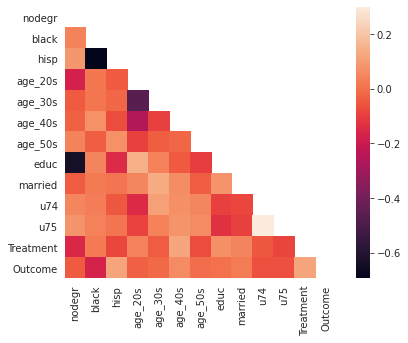

In [16]:
corr=df.corr()

mask=np.zeros_like(corr)

mask[np.triu_indices_from(mask)]=True

with sns.axes_style("white"):

    f, ax=plt.subplots(figsize=(7, 5))

    ax=sns.heatmap(corr, mask=mask, vmax=.3, square=True)

In [17]:
train_df, test_df=tts(df, test_size=0.2, random_state=42, stratify=df['Treatment'])


[Estimate propensity scores for Inverse Probability Weighting.]
[2021-06-16 09:00:39,933|causallift.context.flexible_context|INFO] Run pipeline (tags: ['011_bundle_train_and_test_data'], SequentialRunner, only_missing: False)
[2021-06-16 09:00:39,939|kedro.pipeline.node|INFO] Running node: bundle_train_and_test_data([args_raw,test_df,train_df]) -> [df_00]
[2021-06-16 09:00:39,942|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2021-06-16 09:00:39,942|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2021-06-16 09:00:39,943|causallift.context.flexible_context|INFO] Run pipeline (tags: ['121_prepare_args', '131_treatment_fractions_', '141_initialize_model'], SequentialRunner, only_missing: False)
[2021-06-16 09:00:39,948|kedro.pipeline.node|INFO] Running node: impute_cols_features([args_raw,df_00]) -> [args_intermediate]
[2021-06-16 09:00:39,948|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2021-06-16 09:00:39,949|kedro.

,nodegr,black,hisp,age_20s,age_30s,age_40s,age_50s,educ,married,u74,u75
coefficient,-0.430233,0.0,-0.689284,0.339679,0.0,1.107636,0.0,-0.020977,0.340289,0.15612,-0.249944


[2021-06-16 09:00:41,408|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2021-06-16 09:00:41,409|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2021-06-16 09:00:41,411|causallift.context.flexible_context|INFO] Run pipeline (tags: ['221_estimate_propensity'], SequentialRunner, only_missing: False)
[2021-06-16 09:00:41,425|kedro.pipeline.node|INFO] Running node: estimate_propensity([args,df_00,propensity_model]) -> [df_01]
[2021-06-16 09:00:41,431|causallift.nodes.estimate_propensity|INFO] 
### Histogram of propensity score for train and test data:


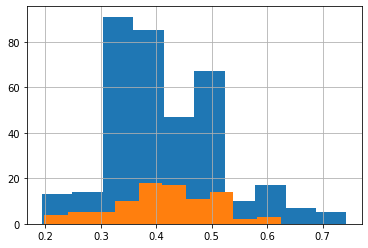

[2021-06-16 09:00:41,609|causallift.nodes.estimate_propensity|INFO] 
### Score Table for logistic regression to calculate propensity score:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,356,2,0.623596,0.616667,0.250000,0.355769,0.569712,0.41573,0.168539
test,89,2,0.550562,0.411765,0.189189,0.259259,0.498441,0.41573,0.191011


[2021-06-16 09:00:41,626|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Train:


,Pred_0,Pred_1
True_0,185,23
True_1,111,37


[2021-06-16 09:00:41,630|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Test:


,Pred_0,Pred_1
True_0,42,10
True_1,30,7


[2021-06-16 09:00:41,637|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2021-06-16 09:00:41,638|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2021-06-16 09:00:41,639|causallift.causal_lift|INFO] ### Treatment fraction in train dataset: 0.4157303370786517
[2021-06-16 09:00:41,639|causallift.causal_lift|INFO] ### Treatment fraction in test dataset: 0.4157303370786517


In [18]:
print('\n[Estimate propensity scores for Inverse Probability Weighting.]')

cl=CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

In [19]:
print('\n[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]')
train_df, test_df=cl.estimate_cate_by_2_models()

print('\n[Show CATE for train dataset]')
display(train_df)

print('\n[Show CATE for test dataset]')
display(test_df)


[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]
[2021-06-16 09:00:41,645|causallift.context.flexible_context|INFO] Run pipeline (tags: ['311_fit', '312_bundle_2_models'], SequentialRunner, only_missing: False)
[2021-06-16 09:00:41,653|kedro.pipeline.node|INFO] Running node: model_for_treated_fit([args,df_01]) -> [treated__model_dict]
[2021-06-16 09:00:41,653|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 1.0
[09:00:41] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[2021-06-16 09:00:41,735|causallift.nodes.model_for_each|INFO] ### Best parameters of the model trained using samples with observational Treatment: 1.0 
 {'objective': 'binary:logistic

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,148,2,0.790541,0.792857,0.982301,0.877470,0.576865,0.763514,0.945946
test,37,2,0.756757,0.750000,1.000000,0.857143,0.550000,0.729730,0.972973


[2021-06-16 09:00:41,757|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2021-06-16 09:00:41,758|kedro.pipeline.node|INFO] Running node: model_for_untreated_fit([args,df_01]) -> [untreated__model_dict]
[2021-06-16 09:00:41,759|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 0.0
[09:00:41] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[2021-06-16 09:00:41,818|causallift.nodes.model_for_each|INFO] ### Best parameters of the model trained using samples with observational Treatment: 0.0 
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interacti

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,208,2,0.725962,0.721591,0.940741,0.816720,0.634754,0.649038,0.846154
test,52,2,0.653846,0.653061,0.969697,0.780488,0.537480,0.634615,0.942308


[2021-06-16 09:00:41,842|kedro.runner.sequential_runner|INFO] Completed 2 out of 3 tasks
[2021-06-16 09:00:41,847|kedro.pipeline.node|INFO] Running node: bundle_treated_and_untreated_models([treated__model_dict,untreated__model_dict]) -> [uplift_models_dict]
[2021-06-16 09:00:41,850|kedro.runner.sequential_runner|INFO] Completed 3 out of 3 tasks
[2021-06-16 09:00:41,850|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2021-06-16 09:00:41,854|causallift.context.flexible_context|INFO] Run pipeline (tags: ['321_predict_proba'], SequentialRunner, only_missing: False)
[2021-06-16 09:00:41,863|kedro.pipeline.node|INFO] Running node: model_for_untreated_predict_proba([args,df_01,uplift_models_dict]) -> [untreated__proba]
[2021-06-16 09:00:41,869|kedro.runner.sequential_runner|INFO] Completed 1 out of 2 tasks
[2021-06-16 09:00:41,873|kedro.pipeline.node|INFO] Running node: model_for_treated_predict_proba([args,df_01,uplift_models_dict]) -> [treated__proba]
[2021

,nodegr,black,hisp,age_20s,age_30s,age_40s,age_50s,educ,married,u74,u75,Treatment,Outcome,Propensity,Proba_if_Treated,Proba_if_Untreated,CATE
index,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0,1,0,0,12.0,1.0,1.0,1.0,1.0,1.0,0.498684,0.972464,0.792031,0.180434
1,0.0,1.0,0.0,0,1,0,0,13.0,1.0,1.0,1.0,0.0,1.0,0.493440,0.988928,0.929328,0.059600
2,1.0,0.0,1.0,0,0,0,0,10.0,0.0,1.0,1.0,0.0,1.0,0.194173,0.983388,0.719180,0.264208
3,1.0,1.0,0.0,0,0,1,0,9.0,1.0,0.0,0.0,0.0,1.0,0.696121,0.989199,0.969703,0.019496
4,1.0,0.0,0.0,1,0,0,0,11.0,0.0,0.0,0.0,0.0,1.0,0.420357,0.929127,0.960661,-0.031534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,1.0,1.0,0.0,0,0,1,0,9.0,0.0,1.0,1.0,1.0,0.0,0.597433,0.718741,0.900707,-0.181966
352,1.0,1.0,0.0,0,1,0,0,11.0,1.0,0.0,0.0,1.0,1.0,0.420506,0.940993,0.708272,0.232722
353,0.0,1.0,0.0,1,0,0,0,12.0,0.0,1.0,1.0,1.0,1.0,0.498531,0.758895,0.453310,0.305585



[Show CATE for test dataset]


,nodegr,black,hisp,age_20s,age_30s,age_40s,age_50s,educ,married,u74,u75,Treatment,Outcome,Propensity,Proba_if_Treated,Proba_if_Untreated,CATE
index,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,1,0,0,0,12.0,0.0,0.0,0.0,1.0,1.0,0.521973,0.633516,0.885238,-0.251722
1,1.0,0.0,1.0,1,0,0,0,9.0,0.0,1.0,1.0,0.0,1.0,0.256840,0.988668,0.911762,0.076906
2,1.0,1.0,0.0,1,0,0,0,11.0,0.0,0.0,0.0,1.0,0.0,0.420357,0.696105,0.629671,0.066434
3,1.0,1.0,0.0,0,1,0,0,11.0,0.0,1.0,0.0,1.0,1.0,0.376398,0.756923,0.314441,0.442481
4,0.0,1.0,0.0,1,0,0,0,12.0,1.0,1.0,1.0,0.0,0.0,0.582833,0.860610,0.444437,0.416173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1,0,0,0,11.0,0.0,1.0,1.0,0.0,0.0,0.397683,0.713979,0.596815,0.117165
85,1.0,1.0,0.0,1,0,0,0,10.0,0.0,1.0,1.0,0.0,1.0,0.402718,0.567890,0.604451,-0.036560
86,1.0,0.0,1.0,1,0,0,0,9.0,0.0,0.0,0.0,1.0,1.0,0.275152,0.987623,0.984909,0.002714


In [20]:
print('\n[Estimate the effect of recommendation based on the uplift model]')
estimated_effect_df = cl.estimate_recommendation_impact()

print('\n[Show the estimated effect of recommendation based on the uplift model]')
display(estimated_effect_df)


[Estimate the effect of recommendation based on the uplift model]
[2021-06-16 09:00:41,931|causallift.context.flexible_context|INFO] Run pipeline (tags: ['511_recommend_by_cate'], SequentialRunner, only_missing: False)
[2021-06-16 09:00:41,938|kedro.pipeline.node|INFO] Running node: recommend_by_cate([args,df_02,treatment_fractions]) -> [df_03]
[2021-06-16 09:00:41,954|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2021-06-16 09:00:41,954|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2021-06-16 09:00:41,959|causallift.context.flexible_context|INFO] Run pipeline (tags: ['521_simulate_recommendation'], SequentialRunner, only_missing: False)
[2021-06-16 09:00:41,970|kedro.pipeline.node|INFO] Running node: model_for_untreated_simulate_recommendation([args,df_03,uplift_models_dict]) -> [untreated__sim_eval_df]
[2021-06-16 09:00:41,987|causallift.nodes.model_for_each|INFO] 
### Simulated outcome for samples with recommended treatment = 0.

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,208,2,0.706731,0.710145,0.993243,0.828169,0.496622,0.711538,0.995192
test,52,2,0.634615,0.634615,1.000000,0.776471,0.500000,0.634615,1.000000


[2021-06-16 09:00:41,996|causallift.nodes.model_for_each|INFO] 
### Simulated effect for samples with recommended treatment = 0.0:


,# samples chosen,observed CVR,# samples recommended,predicted CVR,pred/obs CVR
partition,,,,,
train,208,0.649038,208,0.995192,1.533333
test,52,0.634615,52,1.000000,1.575758


[2021-06-16 09:00:42,001|kedro.runner.sequential_runner|INFO] Completed 1 out of 2 tasks
[2021-06-16 09:00:42,009|kedro.pipeline.node|INFO] Running node: model_for_treated_simulate_recommendation([args,df_03,uplift_models_dict]) -> [treated__sim_eval_df]
[2021-06-16 09:00:42,026|causallift.nodes.model_for_each|INFO] 
### Simulated outcome for samples with recommended treatment = 1.0:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed CVR,predicted CVR
train,148,2,0.675676,0.675676,1.0,0.806452,0.5,0.675676,1.0
test,37,2,0.729730,0.729730,1.0,0.843750,0.5,0.729730,1.0


[2021-06-16 09:00:42,035|causallift.nodes.model_for_each|INFO] 
### Simulated effect for samples with recommended treatment = 1.0:


,# samples chosen,observed CVR,# samples recommended,predicted CVR,pred/obs CVR
partition,,,,,
train,148,0.763514,148,1.0,1.309735
test,37,0.729730,37,1.0,1.370370


[2021-06-16 09:00:42,042|kedro.runner.sequential_runner|INFO] Completed 2 out of 2 tasks
[2021-06-16 09:00:42,042|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2021-06-16 09:00:42,046|causallift.context.flexible_context|INFO] Run pipeline (tags: ['531_estimate_effect'], SequentialRunner, only_missing: False)
[2021-06-16 09:00:42,056|kedro.pipeline.node|INFO] Running node: estimate_effect([args,treated__sim_eval_df,untreated__sim_eval_df]) -> [estimated_effect_df]
[2021-06-16 09:00:42,060|causallift.nodes.utils|INFO] 
## Overall simulated effect of recommendation based on the uplift modeling:


,# samples,observed CVR,predicted CVR,pred/obs CVR
partition,,,,
train,356,0.696629,0.997191,1.431452
test,89,0.674157,1.000000,1.483333


[2021-06-16 09:00:42,065|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2021-06-16 09:00:42,065|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.

[Show the estimated effect of recommendation based on the uplift model]


,# samples,observed CVR,predicted CVR,pred/obs CVR
partition,,,,
train,356,0.696629,0.997191,1.431452
test,89,0.674157,1.000000,1.483333


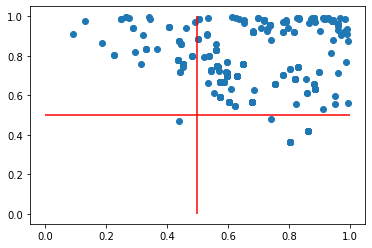

In [21]:
plt.scatter(train_df.Proba_if_Untreated, train_df.Proba_if_Treated)
plt.hlines(.5, 0, 1, colors='r')
plt.vlines(.5, 0, 1, colors='r');

# Tutorial CausalNex 

### Desde https://causalnex.readthedocs.io/

Este tutorial es un ejemplo de uso de CausalNex para estimar si un estudiante aprobabará o suspenderá un examen, basándose en características como relaciones familiares, soporte escolar y otros. Se usará el dataset de [Student Performance](https://archive.ics.uci.edu/ml/datasets/Student+Performance) publicado en [UCI Machine Learning Repository.](http://archive.ics.uci.edu/ml/index.php).

La características del dataset son:

+ 1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
+ 2 sex - student's sex (binary: 'F' - female or 'M' - male)
+ 3 age - student's age (numeric: from 15 to 22)
+ 4 address - student's home address type (binary: 'U' - urban or 'R' - rural)
+ 5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
+ 6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
+ 7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
+ 8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
+ 9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
+ 10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
+ 11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
+ 12 guardian - student's guardian (nominal: 'mother', 'father' or 'other')
+ 13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
+ 14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
+ 15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)
+ 16 schoolsup - extra educational support (binary: yes or no)
+ 17 famsup - family educational support (binary: yes or no)
+ 18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
+ 19 activities - extra-curricular activities (binary: yes or no)
+ 20 nursery - attended nursery school (binary: yes or no)
+ 21 higher - wants to take higher education (binary: yes or no)
+ 22 internet - Internet access at home (binary: yes or no)
+ 23 romantic - with a romantic relationship (binary: yes or no)
+ 24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
+ 25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)
+ 26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)
+ 27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
+ 28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
+ 29 health - current health status (numeric: from 1 - very bad to 5 - very good)
+ 30 absences - number of school absences (numeric: from 0 to 93)
+ 31 G1 - first period grade (numeric: from 0 to 20)
+ 31 G2 - second period grade (numeric: from 0 to 20)
+ 32 G3 - final grade (numeric: from 0 to 20, output target)

## Estructura 

Se puede definir la estructura de una red bayesiana (Bayesian Network - BN) basándose en el machine learning, el conocimiento experto o una combinación de ambos, donde expertos y algoritmos contribuyen igualmente a la solución del problema.

Sin importar de qué manera sea, es fundamental validar la estructura evaluando la BN (esto se verá luego). En ésta sección nos centraremos en definir la estructura.



## Estructura desde el conocimiento experto

Podemos definir manualmente la estructura del modelo especificando las relaciones entre diferentes características.

Primero, debemos crear una estructura vacía.

In [22]:
import warnings
warnings.simplefilter('ignore')

In [23]:
from causalnex.structure import StructureModel

sm=StructureModel()
sm

Ahora, podemos especificar las relaciones entre características. Por ejemplo, supongamos que el experto nos dice que existe la siguiente relación causal: 

+ health -> absences   (salud -> ausencias)
+ health -> G1         (salud -> notas del primer semestre)


Podemos añadir esas relaciones a la estructura de nuestro modelo:

In [24]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

## Visualizando la estructura

Podemos examinar el StructureModel observando la salida de sm.edges

In [25]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

pero a menudo es más intuitivo visualizarlo. CausalNex tiene un módulo de plot (pygraphviz) que nos permite hacer eso:

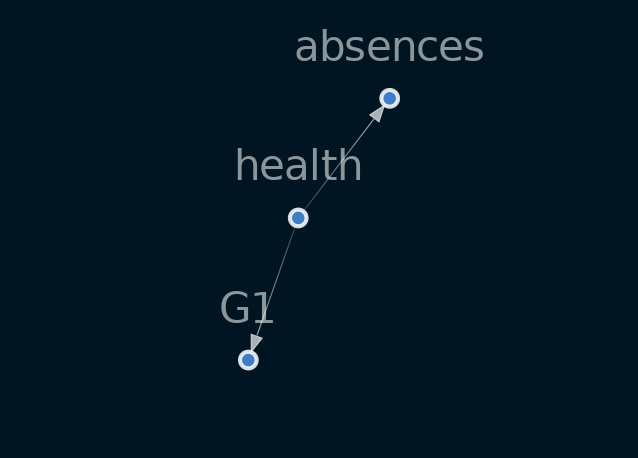

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [ ]:
help(plot_structure)

## Estructura desde ML

Según crece el número de variables, o cuando no existe conocimiento experto, puede volverse tedioso definir toda la estructura de manera manual. Podemos usar CausalNex para extraer la estructura desde los datos. El algoritmo que se va a usar aquí es [NOTEARS](https://arxiv.org/abs/1803.01422).

Para extraer la estructura, podemos usar todo el dataframe. No siempre es necesario usar train_test_split, dado que la estructura es un esfuerzo conjunto entre máquina y expertos.

Pero antes de empezar, debemos procesar nuestros datos para poder alimentar el algoritmo.

## Preparando los datos

In [28]:
import pandas as pd


data=pd.read_csv('../data/student-por.csv', delimiter=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


Observando los datos, podemos ver que existen características numéricas y no-numéricas (categóricas). Podemos eliminar ciertas características 'sensibles' como el género, que no queremos usar en nuestro modelo.

In [29]:
drop_col=['school', 'sex', 'age', 'Mjob', 'Fjob', 'reason', 'guardian']

data=data.drop(columns=drop_col)
data.head()

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


Ahora, queremos que toda nuestra data sea numérica, puesto que es lo que espera el algoritmo NOTEARS. Podemos hacer esto con LabelEncoding.

In [30]:
import numpy as np

struct_data=data.copy()

non_numeric_columns=list(struct_data.select_dtypes(exclude=[np.number]).columns)
non_numeric_columns

['address',
 'famsize',
 'Pstatus',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [31]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

for col in non_numeric_columns:
    struct_data[col]=le.fit_transform(struct_data[col])

struct_data.head()

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13


Llegados hasta aquí, ya podemos aplicar NOTEARS para que aprenda la estructura...

In [32]:
%%time

from causalnex.structure.notears import from_pandas

sm=from_pandas(struct_data)

[2021-06-16 09:00:42,671|root|INFO] Learning structure using 'NOTEARS' optimisation.
CPU times: user 13min, sys: 19min, total: 32min 1s
Wall time: 2min 41s


In [33]:
#help(from_pandas)

... y visualizarla.

In [ ]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)

Image(viz.draw(format='png'))

La razón por la que tenemos un grafo completamente conectado es que no hemos aplicado un umbral (threshold) a las aristas 'débiles'. Esto se puede hacer de dos maneras distintas, o se especifica el valor del parámetro w_threshold en el método from_pandas, o podemos eliminar las aristas con el método remove_edges_below_threshold.

In [35]:
sm.remove_edges_below_threshold(0.8)

In [ ]:

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))


En esta estructura, podemos ver que hay algunas relaciones que parecen ser intuitivamente correctas:

+ Pstatus afecta a famrel - Si los padres están separados, la calidad de las relaciones familiares puede empobrecer el resultado.
+ internet afecta a absences - La presencia de conexión a Internet en el hogar puede causar que el estudiante se salte las clases.
+ studytime afecta a G1 - Tiempos más largos de estudio deberían de tener un impacto positivo en el resultado del estudiante.

Sin embargo, hay algunas relaciones que son ciertamente incorrectas:

+ higher afecta a Mother’s education (Medu) - Esta relación no tiene sentido, ya que el hecho de que un estudiante desee tener educación superior no afecta a la educación de la madre. Esta relación podría ser al contrario. 


Para evitar esas relaciones erróneas, podemos volver a extraer la estructura añadiendo algunas restricciones:

In [36]:
%%time

sm=from_pandas(struct_data, tabu_edges=[('higher', 'Medu')], w_threshold=0.8)

[2021-06-16 09:03:59,424|root|INFO] Learning structure using 'NOTEARS' optimisation.
CPU times: user 28min 5s, sys: 40min 20s, total: 1h 8min 25s
Wall time: 6min 51s


In [ ]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))


## Modificando la estructura

Para corregir relaciones erróneas, podemos incorporar conocimiento experto en el modelo después de crear la estructura. Podemos modificar la estructura añadiendo o borrando aristas. Por ejemplo:

In [37]:
sm.add_edge('failures', 'G1')

sm.remove_edge('Pstatus', 'G1')

sm.remove_edge('address', 'G1')

Ahora podemos visualizar la nueva estructura para confirmar que sea razonable.

In [ ]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))


Podemos ver que hay dos subgrafos en la visualización:  Dalc->Walc y otro subgrafo grande. Podemos extraer el subgrafo más grande con StructureModel llamando al método get_largest_subgraph().

In [38]:
sm = sm.get_largest_subgraph()

In [ ]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))


Después de decidir la estructura final del modelo, podemos instanciar una red bayesiana (BayesianNetwork).

In [39]:
from causalnex.network import BayesianNetwork

bn=BayesianNetwork(sm)
bn

Ahora ya estamos listos para seguir adelante con el aprendizaje de las distribuciones de probabilidad condicionada de diferentes características en la red bayesiana.

## Ajustando la Distribución Condicional de una Red Bayesiana

### Preparando la Discretización de los Datos


Las redes bayesianas en CausalNex solo soportan distribuciones discretas. Cualquier característica continua, o características con un gran número de categorias, deben ser discretizadas antes de entrenar la red bayesiana. Los modelos que contengan variables como muchos posibles valores, típicamente tendrán un mal ajuste y un bajo rendimiento.

Por ejemplo, consideremos P(G2|G1), donde G1 y G2 tienen valores posibles entre 0 y 20. La distribución discreta de probabilidad condicionada queda definida usando 21x21 (441) posibles combinaciones, la mayoría de las cuales será improbable observar.

CausalNex provee algunos metodo de ayuda que hacen más fácil la discretización. Comencemos por reducir el número de categorías en algunas de las variables categóricas combinando valores similares. Convertiremos características numéricas en categoricas por discretización y luego se les asignarán las correspodientes etiquetas.

### Cardinalidad de las Características Categóricas

Para reducir la cardinalidad de las características categoricas podemos definir un map {viejo_valor: nuevo_valor}, y usarlo para actualizar la característica. Por ejemplo, en la variable tiempo de estudio (studytime), si es mayor que 2 (2 significa de 2 a 5 horas de estudio, ver la descripción arriba o visitar https://archive.ics.uci.edu/ml/datasets/Student+Performance) pondremos long-studytime, y para el resto se pondrá short-studytime.

In [40]:
discretised_data=data.copy()

data_vals={col: data[col].unique() for col in data.columns}


failures_map={v: 'no-failure' if v==[0]
              else 'have-failure' for v in data_vals['failures']}


studytime_map={v: 'short-studytime' if v in [1,2]
               else 'long-studytime' for v in data_vals['studytime']}

Una vez que hemos definido los map {viejo_valor: nuevo_valor} podemos actualizar cada variable, aplicando la transformación.

In [41]:
discretised_data['failures']=discretised_data['failures'].map(failures_map)

discretised_data['studytime']=discretised_data['studytime'].map(studytime_map)

### Discretizando Característica Numéricas

Para pasar de numérico a categórico, primero debemos discretizar. CausalNex tiene una clase para esto llamada
causalnex.discretiser.Discretiser, la cual soporta varios métodos de discretización. Para nuestros datos, se aplicará el método 'fixed', dando valores fijos que definen los límites de la categoría (básicamente es hacer binning). Por ejemplo, la variable ausencias (absences) será discretizada en las categorías <1, de 1 a 9, y >=10. Cada una de ellas se etiquetará con un número entero desde cero.

In [42]:
from causalnex.discretiser import Discretiser



discretised_data['absences']=Discretiser(method='fixed',
                             numeric_split_points=[1, 10]).transform(discretised_data['absences'].values)

discretised_data['G1']=Discretiser(method='fixed',
                                   numeric_split_points=[10]).transform(discretised_data['G1'].values)

discretised_data['G2']=Discretiser(method='fixed',
                                   numeric_split_points=[10]).transform(discretised_data['G2'].values)

discretised_data['G3']=Discretiser(method='fixed',
                                   numeric_split_points=[10]).transform(discretised_data['G3'].values)

[2021-06-16 09:14:22,919|root|WARNING] MDLP was not imported successfully


### Crear Etiquetas para Características Numéricas 

Para que las categorías discretizadas sean más legibles, podemos mapear las etiquetas de la misma manera que hicimos con las variables categóricas para que tengan un significado más evidente.

In [43]:
absences_map = {0: 'No-absence', 1: 'Low-absence', 2: 'High-absence'}

G1_map = {0: 'Fail', 1: 'Pass'}
G2_map = {0: 'Fail', 1: 'Pass'}
G3_map = {0: 'Fail', 1: 'Pass'}



discretised_data['absences'] = discretised_data['absences'].map(absences_map)

discretised_data['G1'] = discretised_data['G1'].map(G1_map)
discretised_data['G2'] = discretised_data['G2'].map(G2_map)
discretised_data['G3'] = discretised_data['G3'].map(G3_map)

## Train_Test_Split
Al igual que en muchos otros modelo de machine learning, usaremos train_test_split para validar nuestros resultados.

In [44]:
# Split 90% train y 10% test
from sklearn.model_selection import train_test_split

train, test=train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

## Modelo de Probabilidad

Con la estructura del modelo ya obtenida y los datos discretizados, ya podemos ajustar la distribución de probabilidad de la red bayesiana. Para ello, el primer paso es especificar todos los estados en los que puede estar cada nodo. Esto se puede hacer desde los datos o se puede generar un diccionario con los valores de los nodos. Nosotros vamos a usar todo el dataset para evitar casos donde el estado del nodo exista en el test pero no exista en el train. Para aplicaciones en el mundo real, podría ser necesario usar diccionarios.

In [45]:
bn=bn.fit_node_states(discretised_data)

## Ajuste de las Distribuciones de Probabilidad Condicional

El método fit_cpds de la red bayesiana (BayesianNetwork) acepta un dataset para aprender las distribuciones de probabilidad condicionada (CPDs por las siglas en inglés) de cada nodo, junto con un método que indica como hacer esta ajuste.

In [46]:
bn=bn.fit_cpds(train, method='BayesianEstimator', bayes_prior='K2')

In [47]:
help(BayesianNetwork.fit_cpds)

Help on function fit_cpds in module causalnex.network.network:

fit_cpds(self, data: pandas.core.frame.DataFrame, method: str = 'MaximumLikelihoodEstimator', bayes_prior: str = None, equivalent_sample_size: int = None) -> 'BayesianNetwork'
    Learn conditional probability distributions for all nodes in the Bayesian Network, conditioned on
    their incoming edges (parents).
    
    Args:
        data: dataframe containing one column per node in the Bayesian Network.
        method: how to fit probabilities. One of:
                - "MaximumLikelihoodEstimator": fit probabilities using Maximum Likelihood Estimation;
                - "BayesianEstimator": fit probabilities using Bayesian Parameter Estimation. Use bayes_prior.
        bayes_prior: how to construct the Bayesian prior used by method="BayesianEstimator". One of:
                     - "K2": shorthand for dirichlet where all pseudo_counts are 1
                             regardless of variable cardinality;
              

Una vez obtenidas las CPDs, podemos inspeccionarlas a través de sus propiedades, que vienen en un diccionario tipo nodo->cpd.

In [48]:
bn.cpds['G1']

failures    have-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                0.75        0.806452            0.5            0.75   
Pass                0.25        0.193548            0.5            0.25   

failures                                                                 \
higher               yes                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5        0.612245            0.5            0.75   
Pass                 0.5        0.387755            0.5            0.25   

failures      no-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5        0.612903            0.5             0.5   
Pass                 0.5        0.387097            0.5             0.5   

failures                                                                 
higher               yes                                                 
schoolsup             no                            yes                  
studytime long-studytime short-studytime long-studytime short-studytime  
G1                                                                       
Fail            0.032967         0.15016       0.111111        0.255814  
Pass            0.967033         0.84984       0.888889        0.744186

Los diccionarios de las CPDs están multi-indexados, por eso la función loc puede ser una manera muy útil de interactuar con ellos. 

## Predecir el Estado dados los Datos de Entrada 

El método de predicción de la red bayesiana nos permite hacer predicciones basándonos en los datos. Por ejemplo, queremos predecir si un estudiante suspenderá o aprobará sus examenes basándonos en los datos de entrada. Imagina que tenemos unos datos de entrada del estudiante tales que: 

In [49]:
discretised_data.loc[18, discretised_data.columns != 'G1']

address                     U
famsize                   GT3
Pstatus                     T
Medu                        3
Fedu                        2
traveltime                  1
studytime     short-studytime
failures         have-failure
schoolsup                  no
famsup                    yes
paid                      yes
activities                yes
nursery                   yes
higher                    yes
internet                  yes
romantic                   no
famrel                      5
freetime                    5
goout                       5
Dalc                        2
Walc                        4
health                      5
absences          Low-absence
G2                       Fail
G3                       Fail
Name: 18, dtype: object

Con estos datos, queremos predecir si el estudiante suspenderá su examen. Intuitivamente, deberíamos esperar que este estudiante suspenda porque estudia poco tiempo y ya ha suspendido anteriormente. Veamos como funciona la red bayesiana en este caso:

In [50]:
predictions=bn.predict(discretised_data, 'G1')

In [51]:
print('La predición es \'{prediction}\''.format(prediction=predictions.loc[18, 'G1_prediction']))

La predición es 'Fail'


La predicción realizada por la red bayesiana es que el estudiante suspende. Comparemos con la verdad:

In [52]:
print('La verdad es \'{truth}\''.format(truth=discretised_data.loc[18, 'G1']))

La verdad es 'Fail'


Es el mismo resultado.

## Calidad del modelo

Para evaluar la calidad del modelo, CausalNex tiene dos formas: un reporte de clasificación (Classification Report) y la característica operativa del receptor (curva ROC) además del área bajo la curva ROC (AUC). Se discutirán ambas a continuación.


### Reporte de Clasificación

Para obtener un reporte de clasificación usando una red bayesiana, se necesita dar un set de test, y el nodo que estamos tratando de clasificar. El reporte predecirá el nodo objetivo para todas las filas del test, y evaluará como de bien se hacen esas predicciones.

In [53]:
from causalnex.evaluation import classification_report

classification_report(bn, test, 'G1')

{'G1_Fail': {'precision': 0.7777777777777778,
  'recall': 0.5833333333333334,
  'f1-score': 0.6666666666666666,
  'support': 12},
 'G1_Pass': {'precision': 0.9107142857142857,
  'recall': 0.9622641509433962,
  'f1-score': 0.9357798165137615,
  'support': 53},
 'accuracy': 0.8923076923076924,
 'macro avg': {'precision': 0.8442460317460317,
  'recall': 0.7727987421383649,
  'f1-score': 0.8012232415902141,
  'support': 65},
 'weighted avg': {'precision': 0.8861721611721611,
  'recall': 0.8923076923076924,
  'f1-score': 0.8860973888496825,
  'support': 65}}

Este reporte muestra que el modelo que hemos definido es capaz de clasificar si un estudiante aprobará sus examenes razonablemente bien.

Para las predicciones donde el estudiante suspende, la precisión es buena, pero el recall es malo. Esto implica que podemos confiar en las predicciones para esa clase cuando se hacen, pero probablemente estaremos obviando algunas predicciones que deberiamos haber hecho. Tal vez esas predicciones no realizadas son el resultado de algo no considerado en nuestra estructura, esto podría ser un área interesante a explorar.


### ROC / AUC

La característica operativa del receptor (curva ROC), y el área debajo de la curva ROC (AUC) se pueden obtener usando el método roc_auc del modulo de evaluación de CausalNex. De nuevo, debemos tener hecho el train_test_split. La curva ROC se calcula por predicciones (micro-averaging) hechas sobre todas los estados (clases) del nodo objetivo.

In [54]:
from causalnex.evaluation import roc_auc

roc, auc=roc_auc(bn, test, 'G1')
auc

0.9181065088757396

El valor AUC para nuestro modelo es alto, lo cual nos dice que funciona bien. 

## Consultando las Marginales

Despúes de iterar sobre nuestra estructura, las CPDs y validar la calidad del modelo, podemos consultar a nuestro modelo bajo diferentes observaciones para generar nuevas ideas.



### Marginales de Referencia

Podemos realizar una consulta para ver las marginales de referencia que reflejen la población como un todo. Primero tenemos que actualizar nuestro modelo usando todo el dataset.

In [55]:
bn=bn.fit_cpds(discretised_data, method='BayesianEstimator', bayes_prior='K2')

[2021-06-16 09:14:46,799|root|WARNING] Replacing existing CPD for address
[2021-06-16 09:14:46,799|root|WARNING] Replacing existing CPD for absences
[2021-06-16 09:14:46,800|root|WARNING] Replacing existing CPD for Pstatus
[2021-06-16 09:14:46,800|root|WARNING] Replacing existing CPD for famrel
[2021-06-16 09:14:46,801|root|WARNING] Replacing existing CPD for studytime
[2021-06-16 09:14:46,802|root|WARNING] Replacing existing CPD for G1
[2021-06-16 09:14:46,802|root|WARNING] Replacing existing CPD for failures
[2021-06-16 09:14:46,802|root|WARNING] Replacing existing CPD for schoolsup
[2021-06-16 09:14:46,803|root|WARNING] Replacing existing CPD for paid
[2021-06-16 09:14:46,803|root|WARNING] Replacing existing CPD for higher
[2021-06-16 09:14:46,804|root|WARNING] Replacing existing CPD for internet
[2021-06-16 09:14:46,804|root|WARNING] Replacing existing CPD for G2
[2021-06-16 09:14:46,805|root|WARNING] Replacing existing CPD for G3


Podemos ignorar estos warnings, nos están diciendo que se sustituyen las CPDs existentes.

Para la inferencia, debemos crear un nuevo InferenceEngine para la red bayesiana que nos permita consultar el modelo. El método query calculará las verosimilitudes marginales de todos los estados para todos los nodos.

In [56]:
from causalnex.inference import InferenceEngine

ie=InferenceEngine(bn)

marginals=ie.query()
marginals['G1']

{'Fail': 0.25260687281677224, 'Pass': 0.7473931271832277}

La salida observada nos dice que P(G1=Fail)=0.25, y P(G1=Pass)=0.75. Como comprobación rápida, podemos calcular la proporción de Fail en el dataset, debería ser aproximadamente lo mismo.

In [57]:
import numpy as np


labels, counts=np.unique(discretised_data['G1'], return_counts=True)

list(zip(labels, counts))

[('Fail', 157), ('Pass', 492)]

La proporción de estudiantes que suspenden es 157/(157+492)=0.242 , lo cual está muy cerca de la verosimilitud calculada.

## Marginales después de las Observaciones

También podemos consultar las marginales de los estados en nuestra red dadas algunas observaciones. Estas observaciones se pueden hacer en cualquier sitio de la red, y su impacto se propagará a través del nodo de interés.

Veamos la diferencia en G1 basándonos en el tiempo de estudio.

In [58]:
marginals_short=ie.query({'studytime': 'short-studytime'})
marginals_long=ie.query({'studytime': 'long-studytime'})

print('Marginal G1 | Short Studtyime', marginals_short['G1'])
print('Marginal G1 | Long Studytime', marginals_long['G1'])

Marginal G1 | Short Studtyime {'Fail': 0.2776556433482524, 'Pass': 0.7223443566517477}
Marginal G1 | Long Studytime {'Fail': 0.15504850337837614, 'Pass': 0.8449514966216239}


Basándonos en los datos, podemos ver que los estudiantes que estudian más tiempo tienen más probabilidad de aprobar los exámenes.

## Haciendo Cálculos

CausalNex también soporta la realización de cálculos (Do-Calculus), permitiendo hacer intervenciones específicas. En esta sección veremos los métodos para hacer esto y que significan.

### Actualizando la Distribución de un Nodo

Podemos aplicar una intervención a cualquier nodo en nuestros datos, actualizando su distribución usando un operador. Se puede pensar que es algo como preguntar al modelo: ¿Qué pasaría si algo fuera diferente?. Por ejemplo, podríamos preguntar que ocurriría si el 100% de los estudiantes desean educación superior.

In [59]:
print('distribution before do', ie.query()['higher'])

ie.do_intervention('higher',
                   {'yes': 1.0,
                    'no': 0.0})


print('distribution after do', ie.query()['higher'])

distribution before do {'no': 0.10752688172043011, 'yes': 0.8924731182795698}
distribution after do {'no': 0.0, 'yes': 0.9999999999999998}


### Reestableciendo la Distribución de un Nodo

Podemos resetear cualquier intervención que hayamos hecho usando el método reset_intervention, dándole el nodo que queremos resetear.

In [60]:
ie.reset_do('higher')


ie.query()['higher']

{'no': 0.10752688172043011, 'yes': 0.8924731182795698}

### Efecto de la Intervención en las Marginales 

De nuevo, podemos usar query para examinar los efectos que provoca la intervención sobre las marginales. En este caso, queremos ver como cambia la verosimilitud de conseguir el aprobado si el 100% de los estudiantes quisieran tener educación superior.

In [61]:
print('marginal G1', ie.query()['G1'])

ie.do_intervention('higher',
                   {'yes': 1.0,
                    'no': 0.0})


print('updated marginal G1', ie.query()['G1'])

marginal G1 {'Fail': 0.25260687281677224, 'Pass': 0.7473931271832277}
updated marginal G1 {'Fail': 0.20682952942551894, 'Pass': 0.7931704705744809}


En este caso, podemos observar que si el 100% de los estudiantes quisiera educación superior (frente al 90% en toda la población), entonces la tasa de aprobado pasa del 74.7% al 79.3%.